In [74]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
import math
import scipy.stats as stats
from scipy.stats.distributions import chi2

import warnings
warnings.filterwarnings('ignore')

path = '/Users/xichen/Dropbox/Research/Casey/Rarity/Rarity Paper/Code and data/Data/traits_per_collection_values/'

### A list of collections that go through the rarity calculation
### you can use either addresses or collection names to store, input or output data for each collection

# collections_ = ["0x8eb2ee5dbceeadc3ab5929f03361ba0e23701f27"] 
collections_ = ['BearsOnTheBlock','MonsterBlocks']

### take collections one by one to run the calculation 
### or you can use the collections_ above for parallele computing 
collection_ = collections_[0]

traits_value_ = pd.read_csv(path + collection_ + '.csv',index_col=0)

In [ ]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
import math
import scipy.stats as stats
from scipy.stats.distributions import chi2

import warnings
warnings.filterwarnings('ignore')

path = '/Users/xichen/Dropbox/Research/Casey/Rarity/Rarity Paper/Code and data/Data/traits_per_collection_values/'

### A list of collections that go through the rarity calculation
### you can use either addresses or collection names to store, input or output data for each collection

# collections_ = ["0x8eb2ee5dbceeadc3ab5929f03361ba0e23701f27"] 
collections_ = ['BearsOnTheBlock','MonsterBlocks']

### take collections one by one to run the calculation 
### or you can use the collections_ above for parallele computing 
collection_ = collections_[0]

traits_value_ = pd.read_csv(path + collection_ + '.csv',index_col=0)

In [ ]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
import math
import scipy.stats as stats
from scipy.stats.distributions import chi2

import warnings
warnings.filterwarnings('ignore')

path = '/Users/xichen/Dropbox/Research/Casey/Rarity/Rarity Paper/Code and data/Data/traits_per_collection_values/'

### A list of collections that go through the rarity calculation
### you can use either addresses or collection names to store, input or output data for each collection

# collections_ = ["0x8eb2ee5dbceeadc3ab5929f03361ba0e23701f27"] 
collections_ = ['BearsOnTheBlock','MonsterBlocks']

### take collections one by one to run the calculation 
### or you can use the collections_ above for parallele computing 
collection_ = collections_[0]

traits_value_ = pd.read_csv(path + collection_ + '.csv',index_col=0)

In [ ]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import ks_2samp
import math
import scipy.stats as stats
from scipy.stats.distributions import chi2

import warnings
warnings.filterwarnings('ignore')

path = '/Users/xichen/Dropbox/Research/Casey/Rarity/Rarity Paper/Code and data/Data/traits_per_collection_values/'

### A list of collections that go through the rarity calculation
### you can use either addresses or collection names to store, input or output data for each collection

# collections_ = ["0x8eb2ee5dbceeadc3ab5929f03361ba0e23701f27"] 
collections_ = ['BearsOnTheBlock','MonsterBlocks']

### take collections one by one to run the calculation 
### or you can use the collections_ above for parallele computing 
collection_ = collections_[0]

traits_value_ = pd.read_csv(path + collection_ + '.csv',index_col=0)

In [75]:
class rarity_cls():
    
    def __init__(self,traits_value_):
        self.traits_value_ = traits_value_
        
    def run(self):
        '''run all calculations'''
        [traits_count_, traits_freq_, no_tokens_] = self.val2freq(self.traits_value_)
        
        rarity_mat_ = self.rareCalc(traits_freq_)
        rarity_score_ = (rarity_mat_ - rarity_mat_.min()) / (rarity_mat_.max() - rarity_mat_.min())
        rarity_rank_ = self.rareRank(rarity_score_)
        
        rarity_score_['max-min'] = rarity_score_['max'] - rarity_score_['min']
        
        independ = self.traitIndepend(traits_freq_)
        cramersV = self.traitCramersV(traits_freq_)
        
        normalized_rarity_ = self.traitNormalize(traits_value_,traits_count_,traits_freq_)
        
        results = {
                #     'Number of tokens': no_tokens_,
                #    'Trait values': traits_value_,
                #    'Trait counts': traits_count_,
                #    'Trait frequencies': traits_freq_,
                #    'Rarity': rarity_mat_,
                   'Normalized rarity score': normalized_rarity_,
                #    'Rarity score': rarity_score_,
                #    'Rarity rank': rarity_rank_,
                #    'Independence test result': independ,
                #    'Cramers V test result': cramersV
                   }
        return results
        
    def val2freq(self,traits_value_):
        '''convert trait values to trait value frequencies'''
        traits_value_.fillna('NA',inplace=True)
        traits_count_ = pd.DataFrame(index = traits_value_.index)
        for trait in traits_value_.columns.tolist():
            traits_count_[trait] = traits_value_.groupby(trait)[trait].transform('count')
        no_tokens_ = max([max(traits_count_.index.tolist()),len(traits_count_)])
        traits_freq_ = traits_count_/no_tokens_
        return [traits_count_, traits_freq_, no_tokens_]
    
    def rareCalc(self,traits_freq_):
        '''compute rarity under all kinds of measures using trait value frequencies'''
        rarity_mat_ = pd.DataFrame(index = traits_freq_.index)
        rarity_mat_['min'] = traits_freq_.min(axis=1)
        rarity_mat_['max'] = traits_freq_.max(axis=1)
        rarity_mat_['arithmetic'] = self.wpmean(traits_freq_,1)
        rarity_mat_['harmonic'] = self.wpmean(traits_freq_,-1)
        rarity_mat_['geometric'] = self.wpmean(traits_freq_,0)
        rarity_mat_['geometric'] = [np.round(k, 15) for k in rarity_mat_['geometric']]
        return rarity_mat_
    
    def rareRank(self,rarity_score_):
        '''compute rarity ranks based on rarity scores'''
        rarity_rank_ = pd.DataFrame(index = rarity_score_.index)
        for key in rarity_score_.columns.tolist():
            rarity_rank_[key] = rarity_score_[key].rank(method = 'min', ascending = True)
        return rarity_rank_
    
    def wpmean(self,x,p):
        '''supporting function for arithmetic, harmonic, and goemetric rarity calculations'''
        if p == 0:
            temp = (x.product(axis=1))**(1/len(x.columns.tolist()))
        else:
            temp = x**p
            temp = (temp.mean(axis=1))**(1/p)
        return temp
    
    def traitIndepend(self,traits_freq_):
        traits_ = [c for c in traits_freq_.columns.tolist()]
        independ = pd.DataFrame(columns = traits_, index = traits_)
        for i, trait_ in enumerate(traits_[0:-1]):
            for trait_col_ in traits_[(i+1):]:
                temp = pd.crosstab(traits_freq_[trait_], traits_freq_[trait_col_])
                indpdTest = stats.chi2_contingency(temp)
                independ.loc[trait_,trait_col_] = np.round(indpdTest[0],4)
                independ.loc[trait_col_,trait_] = np.round(chi2.ppf(0.95, df = indpdTest[2]),4)
        return independ
    
    def traitCramersV(self,traits_freq_):
        traits_ = [c for c in traits_freq_.columns.tolist()]
        cramersV = pd.DataFrame(columns = traits_, index = traits_)
        for i, trait_ in enumerate(traits_[0:-1]):
            for trait_col_ in traits_[(i+1):]:
                temp = pd.crosstab(traits_freq_[trait_], traits_freq_[trait_col_])
                crmVtest = stats.chi2_contingency(temp)
                N = np.sum(np.sum(temp))
                minimum_dimension = min(temp.shape)-1
                cramersV.loc[trait_,trait_col_] = np.round(np.sqrt((crmVtest[0]/N) / minimum_dimension),4)
        return cramersV
    
    def traitNormalize(self,traits_value_,traits_count_,traits_freq_):
        w = pd.DataFrame(columns = traits_value_.columns.tolist(), index = ['Weight'])
        for c in traits_value_.columns.tolist():
            w.loc['Weight',c] = len(traits_value_[c].value_counts())
        normalized_rarity_ = pd.DataFrame(index= traits_value_.index)
        for style in ['geometric','harmonic','arithmetic']:
            for counts_control in [True, False]:
                counts = [traits_count_ if counts_control == False else traits_freq_][0]
                col_name = 'normalized ' + style + ' by ' + ['counts' if counts_control == False else 'frequencies'][0]
                normalized_rarity_[col_name] = self.normalizeCalc(w,counts,style,col_name,counts_control)[col_name]
        normalized_rarity_ = (normalized_rarity_ - normalized_rarity_.min())/(normalized_rarity_.max() - normalized_rarity_.min())
        return normalized_rarity_
        
    def normalizeCalc(self,w,counts,style,col_name,counts_control):
        if style == 'geometric':
            weights = [w.copy() if counts_control == False else w**(-1)][0]
        elif style in ['harmonic','arithmetic']:
            weights = w.copy()
        else:
            raise ValueError('Wrong value for the style of trait normalization')
        
        weightsum = weights.sum(axis=1).iloc[0]
        weights = pd.DataFrame(np.repeat(weights.values, len(counts), axis=0), index = counts.index, columns = counts.columns)
        
        if style == 'geometric':
            if counts_control == False:
                normalized_rarity_ = np.log(counts)*weights
                normalized_rarity_ = normalized_rarity_.sum(axis=1)
                normalized_rarity_ = normalized_rarity_*(1/weightsum)
                normalized_rarity_ = np.exp(normalized_rarity_)/len(counts)
            else:
                normalized_rarity_ = counts.pow(weights)  
                normalized_rarity_ = normalized_rarity_.prod(axis=1)
                normalized_rarity_ = normalized_rarity_**(1/weightsum)
        elif style == 'harmonic':
            normalized_rarity_ = weights/counts
            normalized_rarity_ = normalized_rarity_.sum(axis=1)
            normalized_rarity_ = normalized_rarity_**(-1)*weightsum    
        elif style == 'arithmetic':
            normalized_rarity_ = weights*counts
            normalized_rarity_ = normalized_rarity_.sum(axis=1)
            normalized_rarity_ = normalized_rarity_/weightsum
        else:
            raise ValueError('Wrong value for the style of trait normalization')
        normalized_rarity_ = pd.DataFrame(normalized_rarity_, columns = [col_name])
        return normalized_rarity_

In [76]:
model = rarity_cls(traits_value_)
results = model.run()
results

{'Number of tokens': 9999,
 'Trait values':               fur   background           eyes       mouth  \
 0             Red       Orange        Serious  Bubble Gum   
 1     Light Brown   Light Blue  Green Glowing       Bored   
 2            Grey  Grass Green          Bored      Normal   
 3            Grey       Purple         Stoned   Moustache   
 4           Brown   Light Blue          Bored     Injured   
 ...           ...          ...            ...         ...   
 9994        Robot  Grass Green          Bored     Big Ooh   
 9995         Blue         Grey       Confused        Open   
 9997         Blue         Grey          Bored       Smile   
 9998        Robot       Yellow    Sun Glasses      Tongue   
 9999  Light Brown       Purple       Confused      Normal   
 
                   clothes             hat         earring  
 0            Hawaii Shirt     Army Helmet              NA  
 1            Hawaii Shirt            Foux  Golden Earring  
 2            Sailor Shirt  

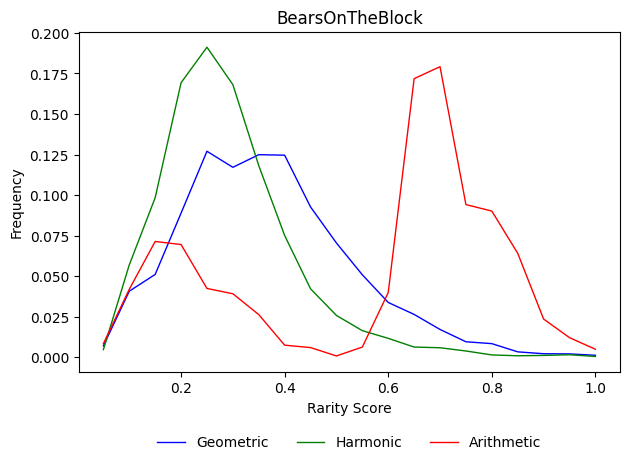

In [77]:
# Rarity score densities
rarity_data = {'Geometric': results['Rarity score']['geometric'],
              'Harmonic': results['Rarity score']['harmonic'],
              'Arithmetic': results['Rarity score']['arithmetic']}
colors = ['b','g','r']

n = {}
bins = list(np.arange(0,1.01,0.05))
for j, d in enumerate(list(rarity_data)):
    n_temp, bins_temp, patches = plt.hist(rarity_data[d], bins=bins)
    n[d] = n_temp/len(rarity_data[d])
    plt.clf()

temp = []
for j, d in enumerate(list(rarity_data)):
    temp += plt.plot(bins[1:],n[d],linewidth=1, color = colors[j])
plt.ylabel("Frequency")
plt.xlabel("Rarity Score")
plt.title(collection_)
plt.legend(temp,list(rarity_data),frameon=False,loc='upper center', bbox_to_anchor=(0.5, -.15),ncol=3)
plt.tight_layout(h_pad=3, w_pad=1)


<Figure size 640x480 with 0 Axes>

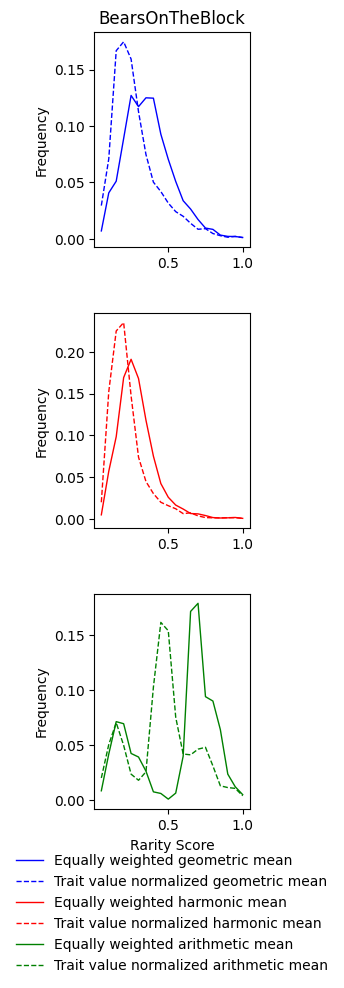

In [78]:
# Rarity score densities before and after trait normalization
rarity_data = dict.fromkeys(['geometric','harmonic','arithmetic'])
for style in list(rarity_data):
    rarity_data[style] = {'Equally weighted ' + style + ' mean': results['Rarity score'][style],
                          'Trait value normalized ' + style + ' mean': results['Normalized rarity score']['normalized ' + style + ' by counts']}
               
colors=['b','r','g']

n = dict.fromkeys(list(rarity_data))
bins = list(np.arange(0,1.01,0.05))
for j, c in enumerate(list(rarity_data)):
    n[c] = {}
    for i, d in enumerate(list(rarity_data[c])):
        n_temp, bins_temp, patches = plt.hist(rarity_data[c][d], bins=bins)
        n[c][d] = n_temp/len(rarity_data[c][d])
        plt.clf()

figure,axs = plt.subplots(3,figsize = (3,10))
temp = []
for j, c in enumerate(list(rarity_data)):
    for i, d in enumerate(list(rarity_data[c])):
        linestyle = ['-' if i == 0 else '--'][0]
        temp += axs[j].plot(bins[1:],n[c][d],linewidth=1, color = colors[j],linestyle = linestyle)
    axs[j].set_ylabel("Frequency")
    if j == 0:
        axs[j].title.set_text(collection_)
    elif j == 2:
        axs[j].set_xlabel("Rarity Score")
plt.legend(temp,[d for c in list(rarity_data) for d in list(rarity_data[c])],frameon=False,loc='upper center', bbox_to_anchor=(0.5, -.15),ncol=1)
plt.tight_layout(h_pad=3, w_pad=1)


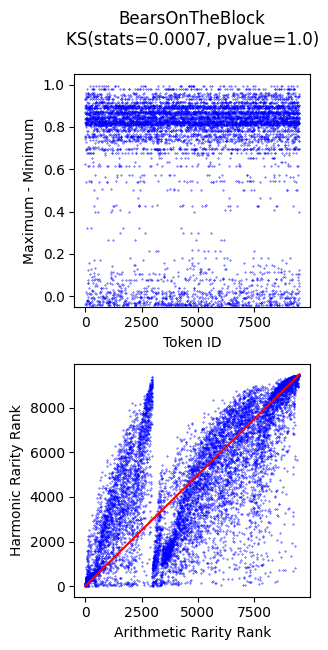

In [80]:
# perform Kolmogorov-Smirnov test
rarity_rank_ = results['Rarity rank']
rarity_score_ = results['Rarity score']
test = ks_2samp(rarity_rank_['arithmetic'],rarity_rank_['harmonic'])
ks_str = 'KS(stats=' + str(np.round(test.statistic,4)) + ', pvalue='+str(np.round(test.pvalue,4))+')'

# QR code and bar code plotting
figure,axs = plt.subplots(2,figsize = (3.3,6.6))
row = 0
axs[row].scatter(np.arange(len(rarity_score_)),rarity_score_['max-min'].values,s=.1,color='r')
axs[row].set_ylim([-0.05,1.05])
axs[row].set_ylabel("Maximum - Minimum")
axs[row].set_xlabel("Token ID")
axs[row].set_title(collection_ +"\n" + ks_str + '\n')
    
row = 1
axs[row].plot([0,len(rarity_score_)],[0,len(rarity_score_)],color='r')
axs[row].scatter(rarity_rank_['arithmetic'],rarity_rank_['harmonic'],s=.1,color='r')
axs[row].set_ylabel("Harmonic Rarity Rank")
axs[row].set_xlabel("Arithmetic Rarity Rank")
    
figure.tight_layout(h_pad=1, w_pad=1)